# Выбор локации для скважины

## Цель

Построить модель для определения региона, где добыча принесёт наибольшую прибыль<br> 
Проанализировать возможную прибыль и риски техникой Bootstrap


## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:<br> 
/datasets/geo_data_0.csv<br> 
/datasets/geo_data_1.csv<br> 
/datasets/geo_data_2.csv<br> 

`id` — уникальный идентификатор скважины<br> 
``f0``, ```f1```, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы)<br> 
product — объём запасов в скважине (тыс. баррелей)<br> 

## Условия задачи:

- Обучить модель линейная регрессия (остальные — недостаточно предсказуемые).<br>
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирать 200 лучших для разработки.<br>
- Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
- Доход с каждой единицы продукта составляет 450 тыс.рублей<br>
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. <br>
- Среди них выбирать регион с наибольшей средней прибылью.<br>


Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. 
- Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as ex
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier

In [202]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [203]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [204]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [205]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [206]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [207]:
display(data_0.head())
display(data_1.head())
display(data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Три набора данных по сто тысяч строк в каждом, без пропусков, в подходящем формате, пред обработка не требуется

In [208]:
display(pd.DataFrame(data_0['product']).describe().T)
display(pd.DataFrame(data_1['product']).describe().T)
display(pd.DataFrame(data_2['product']).describe().T)

,count,mean,std,min,25%,50%,75%,max
product,100000.0,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


,count,mean,std,min,25%,50%,75%,max
product,100000.0,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


,count,mean,std,min,25%,50%,75%,max
product,100000.0,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


Судя по описанию целевого признака в третьем наборе данных количества барелей нефти больше чем в остальных

In [209]:
# Проверим на дубликаты
s = data_0.duplicated().sum()
print(f'Количество дубликатов в data_0 равно {s}')

s = data_1.duplicated().sum()
print(f'Количество дубликатов в data_1 равно {s}')

s = data_2.duplicated().sum()
print(f'Количество дубликатов в data_2 равно {s}')


Количество дубликатов в data_0 равно 0
Количество дубликатов в data_1 равно 0
Количество дубликатов в data_2 равно 0


Полные дубликаты отсутствуют проверять дубликаты в id не станем поскольку этот признак не влияет на обучение модели
И мы его удалим

In [210]:
# удалим столбез id 
data_0 = data_0.drop(columns='id', axis=1)
data_1 = data_1.drop(columns='id', axis=1)
data_2 = data_2.drop(columns='id', axis=1)

Посмотрим на данные в графическом изображение

In [211]:

def data_hist(data, name_data):
    fig, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 2))
    fig.text(0.45, 0.95, f'Гистограммы {name_data}', size='x-large', weight='bold')

    sns.histplot(data['f0'], edgecolor='black', bins=40, linewidth=1, ax=ax)
    sns.histplot(data['f1'], edgecolor='black', bins=40, linewidth=1, ax=ax1)
    sns.histplot(data['f2'], edgecolor='black', bins=30, linewidth=1, ax=ax2)
    sns.histplot(data['product'], edgecolor='black', bins=40, linewidth=1, ax=ax3)

    plt.show()

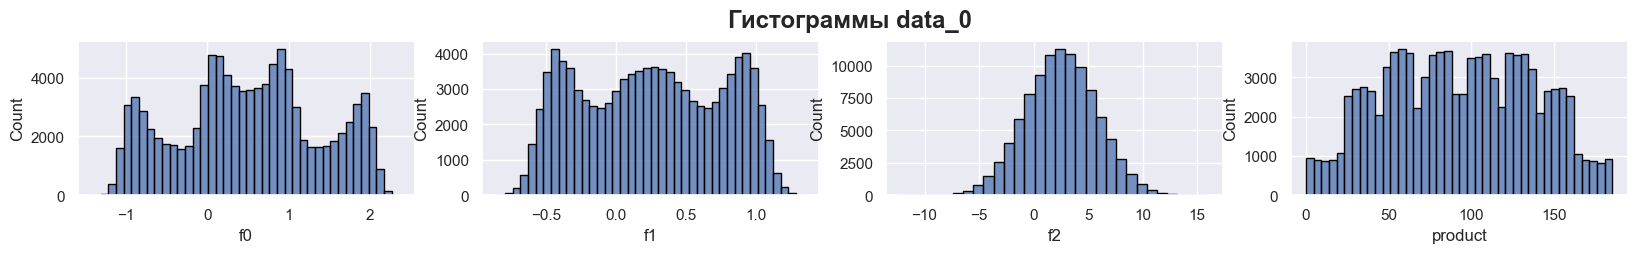

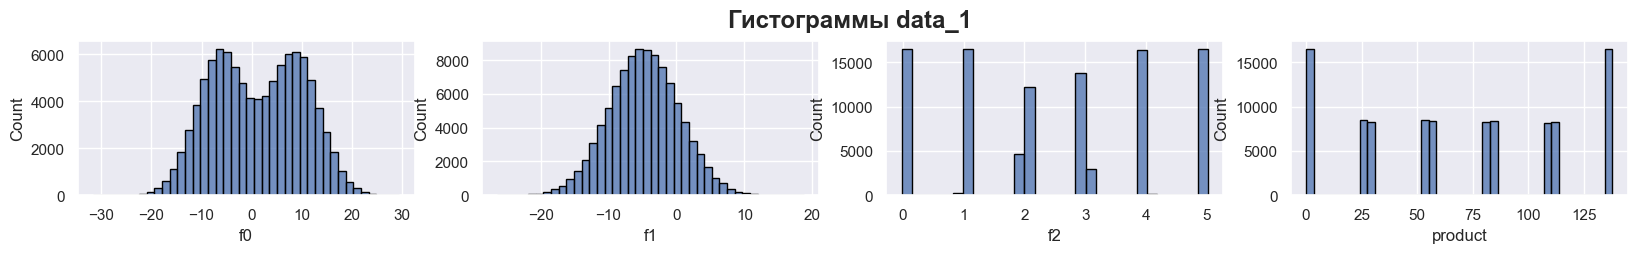

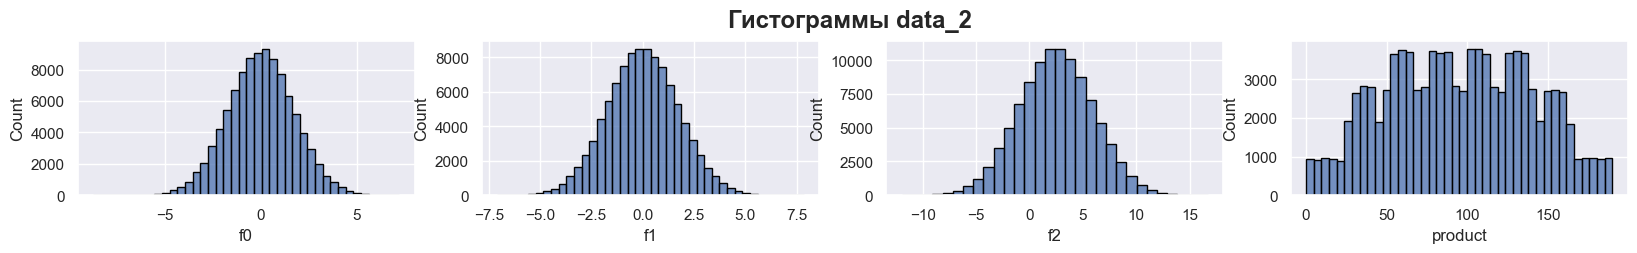

In [212]:
# построим гистограммы наших данных
data_hist(data_0, 'data_0')
data_hist(data_1, 'data_1')
data_hist(data_2, 'data_2')

Вот значит как выглядят синтетические данные)<br>
Видим, что распределение в признаках в большинстве нормальное с одним пиком<br> 
Или близкое к нормальному с множеством пиков с явными группами<br>
Наборы признаков в данных различаются <br>

Проверим на корреляцию

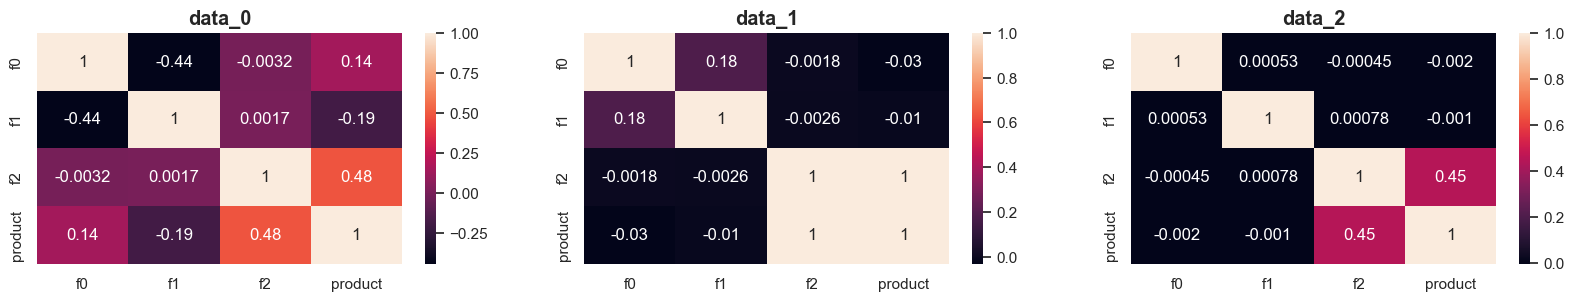

In [213]:
# задаём фигуры для графиков 
fig, axs = plt.subplots(1, 3, figsize=(20, 3))

ax = axs.flat[0]
ax.set_title(f'data_0', weight='bold', size='large')
ax1 = axs.flat[1]
ax1.set_title(f'data_1', weight='bold', size='large')
ax2 = axs.flat[2]
ax2.set_title(f'data_2', weight='bold', size='large')
# посмотрим нп тепловую карту корреляции признаков в данных
sns.heatmap(data_0.corr(), ax=ax, annot=True);
sns.heatmap(data_1.corr(), ax=ax1, annot=True);
sns.heatmap(data_2.corr(), ax=ax2, annot=True);

Обнаружили сильную корреляцию признаков и целевого признака в data_1 <br>
Это может негативно влиять на обучение модели и привести к переобучению<br>
Остальные данные проблемы мультиколлинеарности не имеют<br>

Поделим данные на признаки и целевые признаки <br>
Для дальнейшего масштабирования <br>

In [214]:
# зададим постоянную random_state
RANDOM_STATE = 6568

In [215]:
# функция разбиения на выборки и масштабирования
def split_scale(data):
    features = data.drop(columns='product', axis=1).copy()
    target = data[['product']].copy()

    X_feat, X_val, y_target, y_valit = (train_test_split(features, target, train_size=.75, random_state=RANDOM_STATE))

    scaler = StandardScaler().fit(X_feat)

    X_features = scaler.transform(X_feat)
    X_valid = scaler.transform(X_val)
    return pd.DataFrame(X_features, index=X_feat.index), pd.DataFrame(X_valid, index=X_val.index), y_target, y_valit

In [216]:
# создадим наборы признаков и целевых признаков данных 
X0_features, X0_valid, y0_target, y0_valit = split_scale(data_0)
X1_features, X1_valid, y1_target, y1_valit = split_scale(data_1)
X2_features, X2_valid, y2_target, y2_valit = split_scale(data_2)

In [217]:
# # удалил мультиколлинеарный признак для эксперимента в результате RMSE всех моделей была больше 43
# X0_features, X0_valid = X0_features[[0, 1]], X0_valid[[0, 1]]
# X1_features, X1_valid = X1_features[[0, 1]], X1_valid[[0, 1]]
# X2_features, X2_valid = X2_features[[0, 1]], X2_valid[[0, 1]]

In [218]:
# посмотрим на результат сравним как было и стало 
display(data_0.iloc[y0_target.index].head(3))
display(pd.concat([pd.DataFrame(X0_features, index=y0_target.index), y0_target], axis=1).head(3))
print(f'Индексы признаков и целевого признака равны: {np.array_equal(X0_features.index, y0_target.index)}')
print(f'Длина признаков X2_features {len(X2_features)}.', f'Длина целивых признаков y2_target {len(y2_target)}')
print(f'Длина признаков X2_valid {len(X2_valid)}.', f'Длина целивых признаков y2_valit {len(y2_valit)}')

,f0,f1,f2,product
45496,-0.949500,0.379604,4.506917,120.937545
42436,0.002716,0.277543,-1.680640,82.539635
12636,-0.921722,0.070901,5.698061,25.747513


,0,1,2,product
45496,-1.665213,0.257180,0.616644,120.937545
42436,-0.571687,0.054974,-1.284289,82.539635
12636,-1.633313,-0.354429,0.982586,25.747513


Индексы признаков и целевого признака равны: True
Длина признаков X2_features 75000. Длина целивых признаков y2_target 75000
Длина признаков X2_valid 25000. Длина целивых признаков y2_valit 25000


Данные разбиты на выборки в пропорциях 75/25%<br>
Масштабированы корректно

### Вывод
Познакомились с данными <br>
Три датасета по 100 тысясь строк<br>
По пять столбцов в каждом, 4 в числовом формате и один в строковом<br>
Проверили на полные дубликаты, полных дубликатов нет <br>
Удалили столбец `id` потому, что этот признак не имеет значимости<br>

Построили гистограммы и посмотрели распределение<br>
Распределение в признаках в большинстве нормальное с одним пиком<br>
Или близкое к нормальному с множеством пиков с явными группами<br>

Построили тепловую карту корреляции признаков и обнаружили<br>
Высокую корреляцию признака `f2` и целевого признака `product` в данных data_1<br>
Это может негативно влиять на обучение модели и переобучить её<br>
В лучших условиях этот признак надо удалить<br>

Разделили на признаки и целевые признаки<br>
Разбили на обучающую и валидационную выборку в пропорциях `75/25%`<br>
Обучили `scaler` на обучающей выборке и масштабировали обучающие и валидационные признаки<br>

## Обучение и проверка модели

По условию задания необходимо обучить модель линейной регрессии <br>
Постараемся подобрать гиперпараметры для модели<br>
Первым делом обучим модель стандартно <br>
В последствии с подбором гиперпараметров и сравним результаты<br>

In [219]:
# создадим словарь со спискам наших выборок с признаками и целевыми признаками
sample_dict = {'data_0':[X0_features, X0_valid, y0_target, y0_valit],
               'data_1':[X1_features, X1_valid, y1_target, y1_valit],
               'data_2':[X2_features, X2_valid, y2_target, y2_valit], }

# словарь для хранения результатов
final_result = {'RMSE':[], 'average predicted':[], 'true average':[]}
predict_list = []


# функция обучения моделей всех datasets, rmse and mean
def linear_model(data, final_result=final_result, predict_list=predict_list):
    model = LinearRegression().fit(data[0], data[2])
    predict = model.predict(data[1])
    rmse = metrics.mean_squared_error(data[3], predict, squared=False)
    predict_list.append(pd.DataFrame(predict, index=data[1].index).sort_values(by=0, ascending=False))
    final_result['RMSE'].append(rmse)
    final_result['average predicted'].append(predict.mean())
    final_result['true average'].append(data[3].mean()['product'])


for i in sample_dict:
    linear_model(sample_dict[i])

final_result = pd.DataFrame(final_result, index=['data_0', 'data_1', 'data_2'])

In [220]:
# данные для графического изображения распределения предсказания модели относительно истинного среднего
s1 = pd.Series(predict_list[0][0]).to_frame(name='predict')
s2 = pd.Series(predict_list[1][0]).to_frame(name='predict')
s3 = pd.Series(predict_list[2][0]).to_frame(name='predict')

exam_025 = pd.concat([y0_valit, s1], axis=1, join='inner')
exam_125 = pd.concat([y1_valit, s2], axis=1, join='inner')
exam_225 = pd.concat([y2_valit, s3], axis=1, join='inner')

exam_0 = exam_025.sample(600, random_state=RANDOM_STATE).sort_values(by='product', ascending=False)
exam_1 = exam_125.sample(600, random_state=RANDOM_STATE).sort_values(by='product', ascending=False)
exam_2 = exam_225.sample(600, random_state=RANDOM_STATE).sort_values(by='product', ascending=False)

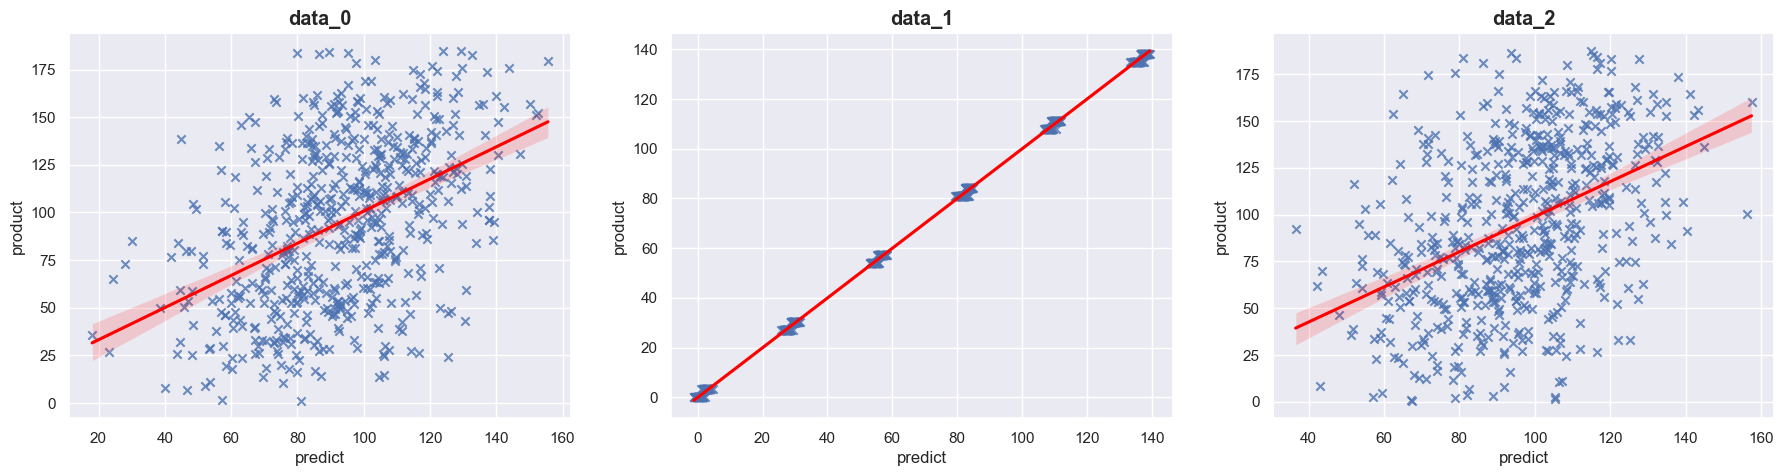

,RMSE,average predicted,true average
data_0,37.797959,92.501016,92.664251
data_1,0.887006,68.863271,68.849404
data_2,39.821302,95.165509,94.756915


In [221]:
# отобразим графически
sns.set_theme()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))

sns.regplot(data=exam_0, x='predict', y='product', ax=ax1, line_kws={'color':'red'}, marker='x')
sns.regplot(data=exam_1, x='predict', y='product', ax=ax2, line_kws={'color':'red'}, marker='x')
sns.regplot(data=exam_2, x='predict', y='product', ax=ax3, line_kws={'color':'red'}, marker='x')

ax1.set_title('data_0', weight='bold', size='large')
ax2.set_title('data_1', weight='bold', size='large')
ax3.set_title('data_2', weight='bold', size='large')

plt.show()
final_result

### Вывод
В результатах видим, что самая маленькая величина RMSE у data_1<br>
RMSE у других данных выше, однако разница в предсказанном среднем и действительном среднем не слишком<br>
Большая, особенно у data_0 всего 163.2 барреля<br>

На графике наблюдаем плотное скопление предсказаний относительно истиной средней в регионе data_1 которые повторяют<br>
Группы данных признака `f2` наблюдаемые ранее на гистограмме Этот эффект вызван высокой корреляцией признака и<br>
Целевого признака При других обстоятельствах считать эту модель удовлетворительной нельзя, но в данном случае условия<br>
Говорят, что признаки не имеют значения, поэтому работам дальше как есть<br>



## Подготовка к расчёту прибыли

In [222]:
# подготовим постоянные переменные
# тестируемое количество скважен
TEST_QUANTITY = 500
# целевое количество скважен
TARGET_QUANTITY = 200
# прибыль за тысячу баррелей
BARREL_1000 = 45000
# бюджет на разработку 200 скважен
BUDGET = 10 ** 9
# максимальный допустимый порог убытков
MAXIMUM_THRESHOLD = 2.5
# Минимальный объём сырья скажены для безубыточной разработки
MINIMUM_VOLUM = BUDGET / TARGET_QUANTITY / BARREL_1000

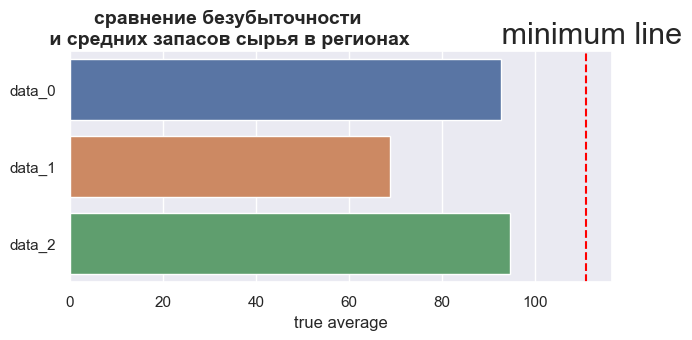

Минимальный объём сырья скажены для безубыточной разработки 111.11 тысяч бар
Средний объём запасов в регионе data_0 равен 92.50 тысяч бар
Средний объём запасов в регионе data_0 равен 68.83 тысяч бар
Средний объём запасов в регионе data_0 равен 95.00 тысяч бар


In [223]:
# график сравнивающий средние истинные запасы с минимальной нормой безубыточности
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot()

ax = sns.barplot(data=final_result, y=final_result.index, x="true average");
fig.suptitle('сравнение безубыточности\n и средних запасов сырья в регионах', x=0.35, y=1.02, fontsize=14,
             fontweight='bold')

ax.text(MINIMUM_VOLUM - 20, -.6, f' minimum line', fontsize=22)
ax = plt.axvline(x=MINIMUM_VOLUM, color='red', linestyle='--');

plt.show()

print(f'Минимальный объём сырья скажены для безубыточной разработки {MINIMUM_VOLUM :.2f} тысяч бар')
print(f'Средний объём запасов в регионе data_0 равен {data_0["product"].mean():.2f} тысяч бар')
print(f'Средний объём запасов в регионе data_0 равен {data_1["product"].mean():.2f} тысяч бар')
print(f'Средний объём запасов в регионе data_0 равен {data_2["product"].mean():.2f} тысяч бар')

### Вывод
Рассчитали минимальный объём запасов сырья в скважине для без убыточной разработки, который равняется 111.11 тысяч <br>
Сравнительный анализ истинно средних запасов и минимального порога показал, что опираясь на средние запасы прибыльной <br>
Добычи нет во всех регионах, но самый убыточный регион data_1 он покрывает только 62% запасов необходимых для <br>
Без убыточной разработки, регион data_2 покрывает 85.%, а data_0 83% запасов

## Расчёт прибыли и рисков

In [224]:
# функция расчета суммарной прибыли по выбранным скважинам
def revenue(real_volume, predicted_volume, random_state, TARGET_QUANTITY=TARGET_QUANTITY):
    predicted_volume = (
        predicted_volume.sample(n=TEST_QUANTITY, random_state=random_state).sort_values(by=0, ascending=False))
    selected = real_volume.loc[predicted_volume[:TARGET_QUANTITY].index]
    if sorted(predicted_volume[:TARGET_QUANTITY].index) != sorted(selected.index):
        print(f"INDEX ERROR")
    elif real_volume.loc[predicted_volume.index].shape[0] != TEST_QUANTITY:
        print(f"SHAPE ERROR:", real_volume.loc[predicted_volume.index].shape[0])
    return BARREL_1000 * selected['product'].sum() - BUDGET

In [225]:
# список с опирационным доходом
revenu_list = []
# заполняем revenu_list расчетной выручкой по регионам
for index, keys in enumerate(sample_dict):
    revenu_list.append(
        revenue(real_volume=sample_dict[keys][3], predicted_volume=predict_list[index], random_state=RANDOM_STATE))

exam_revenu_simple = pd.DataFrame(revenu_list, index=['data_0', 'data_1', 'data_2']).T

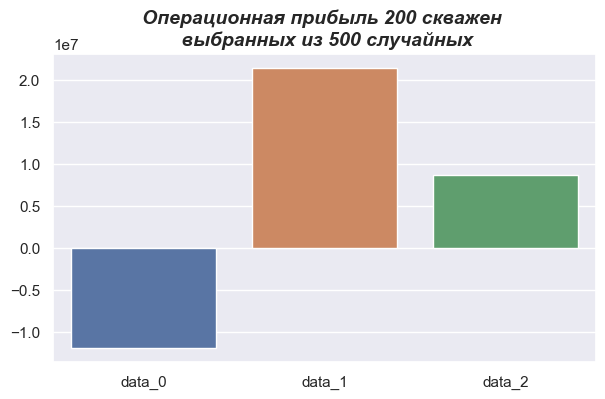

,data_0,data_1,data_2
0,-1.191742e+07,2.151408e+07,8.730634e+06


In [226]:
# посмотрим на графике выглядит
fig = plt.figure(figsize=(7, 4))
(sns.barplot(exam_revenu_simple).set_title('Операционная прибыль 200 скважен \n выбранных из 500 случайных',
                                           dict(fontstyle='oblique', fontweight='bold', fontsize=14)));
plt.show()
exam_revenu_simple

Расчет операционной прибыли 200 скважен выбранных из 500 случайных показал, что регион data_0 имеет операционный убыток<br>
Регион data_1 показал операционную прибыль, немногим больше, 20 миллионов<br>
Регион data_1 начинаем рассматривать как перспективный для добычи <br>
<br>
Регион dada_2 показал операционную прибыль 9 миллионов без трёхсот тысяч<br>
Это тоже хороший показатель посмотрим на вероятность получить убытки <br>
<br>
Посмотрим на доверительный интервал 1000 случайных выборок<br>

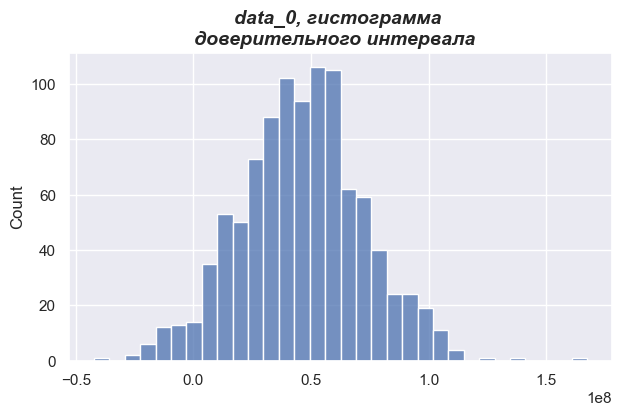

Средняя выручка тысячи случайных выборок двухсот скважен:  46210984.05₽
Доверительный интервал: от -7199533.76₽ до 99366005.31₽
Вероятность получить убыток составляет: 4.1%
############################################################


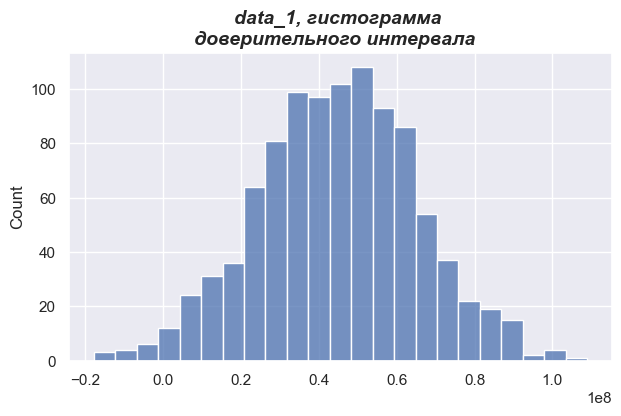

Средняя выручка тысячи случайных выборок двухсот скважен:  44768308.46₽
Доверительный интервал: от 4242119.13₽ до 85453020.29₽
Вероятность получить убыток составляет: 1.3%
############################################################


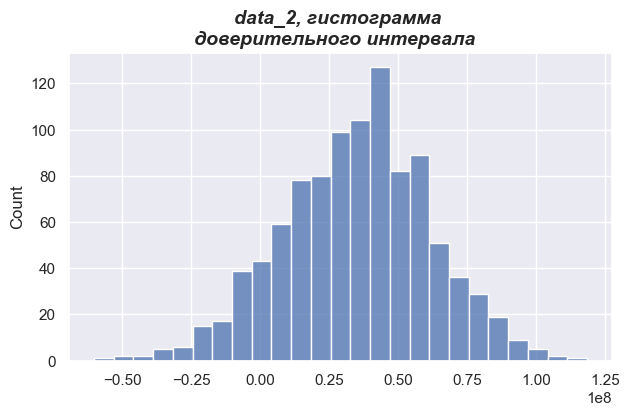

Средняя выручка тысячи случайных выборок двухсот скважен:  34964937.72₽
Доверительный интервал: от -19954384.48₽ до 87095924.78₽
Вероятность получить убыток составляет: 1.1e+01%
############################################################


In [227]:
# запустим вложенный цикл
revenu_list_1000 = []
# проходим по словарю
for index, key in enumerate(sample_dict):
    exam = []
    for _ in range(1000):
        revenu_1000 = (revenue(real_volume=sample_dict[key][3], predicted_volume=predict_list[index],
                               random_state=np.random.randint(0, 9, 4, int)))
        exam.append(revenu_1000)
    revenu_list_1000.append(pd.DataFrame({key:exam}))
    percent = st.percentileofscore(exam, 0, kind='strict')

    fig = plt.figure(figsize=(7, 4))
    (sns.histplot(exam).set_title(f'{key}, гистограмма \nдоверительного интервала  ',
                                  dict(fontstyle='oblique', fontweight='bold', fontsize=14)));
    plt.show()

    print(f'Средняя выручка тысячи случайных выборок двухсот скважен:  {np.mean(exam):.2f}₽')
    print(
        f'Доверительный интервал: от {pd.Series(exam).quantile(0.025):.2f}₽ до {pd.Series(exam).quantile(0.975):.2f}₽')
    print(f'Вероятность получить убыток составляет: {percent:.2}%')
    print('#' * 60)

revenu_frame_1000 = pd.concat([revenu_list_1000[0], revenu_list_1000[1], revenu_list_1000[2]], axis=1)

### Вывод

Расчет операционной прибыли 200 скважен выбранных из 500 случайных показал, что регион data_0 имеет операционный убыток<br>
Регион data_1 показал операционную прибыль, немногим больше, 20 миллионов<br>
Регион data_1 начинаем рассматривать как перспективный для добычи <br>
<br>
Регион dada_2 показал операционную прибыль 9 миллионов без трёхсот тысяч<br>
<br>
Техника Bootstrap исследуемых регионов определила, что для разработки месторождений нефти подходит регион data_1<br>
Доверительный интервал data_1 находится в положительной зоне<br>
Вероятность получить убыток составляет меньше 2.5%<br>
<br>
Другие исследуемые регионы не подходят для разработки, в каждом из них доверительный интервал глубоко лежит в <br>
Отрицательной зоне, вероятность получить убыток значительно превышает допустимый максимальный порог в 2.5% <br>

In [228]:
# соберём финальную таблицу
exam = pd.DataFrame({'mean bootstrap':round(revenu_frame_1000.mean(), 2)}, index=['data_0', 'data_1', 'data_2'])
exam1 = (pd.DataFrame({
    'confidence interval from':[round(revenu_frame_1000['data_0'].quantile(0.025).astype('object'), 2),
                                round(revenu_frame_1000['data_1'].quantile(0.025).astype('object'), 2),
                                round(revenu_frame_1000['data_2'].quantile(0.025).astype('object'), 2)],
    'confidence interval to':[round(revenu_frame_1000['data_0'].quantile(0.975).astype('object'), 2),
                              round(revenu_frame_1000['data_1'].quantile(0.975).astype('object'), 2),
                              round(revenu_frame_1000['data_2'].quantile(0.975).astype('object'), 2)]},
    index=['data_0', 'data_1', 'data_2']))

exam2 = pd.DataFrame({'loss probability':[round(st.percentileofscore(revenu_frame_1000['data_0'], 0, kind='strict'), 2),
                                          round(st.percentileofscore(revenu_frame_1000['data_1'], 0, kind='strict'), 2),
                                          round(st.percentileofscore(revenu_frame_1000['data_2'], 0, kind='strict'),
                                                2)]}, index=['data_0', 'data_1', 'data_2'])
final_result = pd.concat([final_result, exam, exam1, exam2], axis=1)


In [229]:
final_result

,RMSE,average predicted,true average,mean bootstrap,confidence interval from,confidence interval to,loss probability
data_0,37.797959,92.501016,92.664251,46210984.05,-7199533.76,99366005.31,4.1
data_1,0.887006,68.863271,68.849404,44768308.46,4242119.13,85453020.29,1.3
data_2,39.821302,95.165509,94.756915,34964937.72,-19954384.48,87095924.78,10.9


## Вывод финал
Для безубыточной разработки нефтяных скважин подходит регион data_1<br>
Доверительный интервал data_0 лежит от 4242119.13₽ до 85453020.29₽
Имитация 1000 разработок случайных 200 скважин региона data_1 показала <br>
Вероятность получить убыток меньше допустимого максимума<br>

Проведённое исследование трёх наборов данных описывающие характеристики скважен<br>
Каждый датасет по 100 тысяч строк<br>
По пять столбцов в каждом, 4 в числовом формате и один в строковом<br>
Проверили на полные дубликаты, полных дубликатов нет <br>
Удалили столбец `id` потому, что этот признак не имеет значимости<br>
<br>
Распределение в признаках в большинстве нормальное с одним пиком<br>
Или близкое к нормальному с множеством пиков с явными группами<br>
<br>
Обнаружили мультиколлинеарность признака `f2` и  `product` в данных data_1<br>
По причине того, что данные синтетические и признаки не имеют значения оставили без изменения<br>
На этом этапе предположили, что это негативно повлияет на модель и она переобучится<br>
Что и произошло в результате<br>
В лучших условиях этот признак надо удалить<br>
<br>
Разделили на признаки и целевые признаки<br>
Разбили на обучающую и валидационную выборку в пропорциях `75/25%`<br>
Обучили `scaler` на обучающей выборке и масштабировали обучающие и валидационные признаки<br>
<br>
Обучили модели линейной регрессии и получили<br>
data_0: RMSE 37.797959<br>
data_1: RMSE 0.887006<br>
data_2: RMSE 39.821302<br>
разница в предсказанном среднем и действительном среднем не слишком<br>
Большая, особенно у data_0 всего 163.2 барреля<br>
<br>
Рассчитали минимальный объём запасов сырья в скважине для без убыточной разработки, который равняется 111.11 тысяч <br>
Сравнительный анализ истинно средних запасов и минимального порога показал, что опираясь на средние запасы прибыльной <br>
Добычи нет во всех регионах, но самый убыточный регион data_1 он покрывает только 62% запасов необходимых для <br>
Без убыточной разработки, регион data_2 покрывает 85.%, а data_0 83% необходимых запасов<br>
<br>
Расчет операционной прибыли 200 скважен выбранных из 500 случайных показал, что регион data_0 имеет операционный убыток<br>
Регион data_1 показал операционную прибыль, немногим больше, 20 миллионов<br>
Регион dada_2 показал операционную прибыль 9 миллионов без трёхсот тысяч<br>
<br>
Техника Bootstrap исследуемых регионов определила, что для разработки месторождений нефти подходит регион data_1<br>
Доверительный интервал data_1 находится в положительной зоне<br>
Вероятность получить убыток составляет меньше 2.5%<br>
<br>
Другие исследуемые регионы не подходят для разработки, в каждом из них доверительный интервал лежит глубоко в <br>
Отрицательной зоне, вероятность получить убыток значительно превышает допустимый максимальный порог в 2.5% <br>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [х]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован